<a href="https://colab.research.google.com/github/leejielong/yolov1/blob/main/YOLOv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLO Network

Most implementations of YOLO models adapted from the Darknet implementation, where it was originally developed. While pretrained darknet YOLO models can be run in PyTorch, it gives us little control over the architecture. In this notebook we implement YOLOv1 from scratch in PyTorch, trained and validated on the PASCAL VOC 2012 dataset.

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 10 14:59:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    36W / 250W |   3723MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
import os
import time
import numpy as np
import tarfile
from tqdm.notebook import tqdm
import torch
import torchvision
from torch import Tensor
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [38]:
#set global variables
EPOCHS = 100
IMG_SIZE = 500
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.0005
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
IOU_THRESHOLD = 0.5
PC_THRESHOLD = 0.6

S = 8
B = 2
C = 20

SEED = 42
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = -1

LOAD_MODEL = True
LOAD_MODEL_FILE = "/content/drive/MyDrive/Projects/YOLOv1/overfit_sum2.pth.tar"
SAVE_INTERVAL = 10
DATASET_PATH = "/content/dataset/"

###Download Dataset

In [39]:
def download_voc_detection_dataset(dataset_path):
    """
        Downloads the PASCAL VOC 2012 Detection dataset the designated path.

        Args: 
            dataset_path (str): path to store dataset. Ensure at least 2GB space is available,
            preferably on local disk.
    """
    if not os.path.isdir(dataset_path):
        os.mkdir(dataset_path)
        # I hosted a copy of the 2012 VOC dataset via GDrive.
        !gdown https://drive.google.com/u/0/uc?id=1XOm7u2c_CpABfzOYkaFV_5b0KLF9Fmdr -O /content/dataset/VOCtrainval_11-May-2012.tar
        from_path = dataset_path + 'VOCtrainval_11-May-2012.tar'
        to_path = dataset_path
        print(f'Extracting to {dataset_path}...')
        with tarfile.open(from_path, 'r') as tar:
            tar.extractall(to_path)

# download_voc_detection_dataset(dataset_path=DATASET_PATH)

###Utility Functions

In [40]:
def corners_to_midpoints(global_corners,S,B,device='cpu'):
    """
    Converts global corner coordinate format (xmin,ymin,xmax,ymax)
    to local midpoint coordinate format (y,x,h,w). Returns midpoint
    coordinates relative to interior of cell.

    Args:
        global_corners (Tensor[N,S,S,B*5+C]): Model predictions in global corner format (xmin,ymin,xmax,ymax). 
                                    Elements should be in order of [Pc1,xmin1,ymin1,xmax1,ymax1,Pc2,...,C1,C2,...Cn].
        S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
        B (int): Number of bounding boxes per cell
        device (int, optional(default='cpu')): Device type to load tensors to.

    Returns:
        local_midpoints (Tensor[N,S,S,B*5+C]): Model predictions in local midpoint (yxhw) format.
    """

    local_midpoints = global_corners.clone()
    for i in range(B):
        xmin = global_corners[...,1+i*5]
        ymin = global_corners[...,2+i*5]
        xmax = global_corners[...,3+i*5]
        ymax = global_corners[...,4+i*5]

        #global_midpoints state
        local_midpoints[...,1+i*5] = (ymin+ymax)/2 #y
        local_midpoints[...,2+i*5] = (xmin+xmax)/2 #x
        local_midpoints[...,3+i*5] = ymax-ymin #h
        local_midpoints[...,4+i*5] = xmax-xmin #w

        # print(f"global_midpoints: {local_midpoints}")

        #convert to local
        local_midpoints[...,1+i*5] = torch.mul(local_midpoints[...,1+i*5],S).remainder(1) #y
        local_midpoints[...,2+i*5] = torch.mul(local_midpoints[...,2+i*5],S).remainder(1) #x                                         
                                                                                    
    return local_midpoints



def midpoints_to_corners(local_midpoints,S,B,device='cpu'):
    """
    Converts local midpoint coordinate format (y,x,h,w) to
    global corner coordinate format (xmin,ymin,xmax,ymax). 

    Args:
        local_midpoints (Tensor[...,B*5+C]): Model predictions in local midpoint format (yxhw). 
                                    Elements should be in order of [Pc1,y1,x1,h1,w1,Pc2,...,C1,C2,...Cn].
        S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
        B (int): Number of bounding boxes per cell
        device (int, optional(default='cpu')): Device type to load tensors to.

    Returns:
        global_corners (Tensor[N,S,S,B*5+C]): Model predictions in global corner format (xmin,ymin,xmax,ymax).
    """

    batch_size = local_midpoints.shape[0]

    mask = local_midpoints[...,0] != 0


    #create cell_i matrix to indicate the vertical cell index for each cell
    cell_i_matrix = torch.arange(start=0,end=S).reshape(-1,1).repeat(batch_size,S).reshape(-1,S,S).to(device)
    cell_i_matrix *= mask

    #prepare cell_j matrix to indicate the horizontal cell index for each cell
    cell_j_matrix = torch.arange(start=0,end=S).repeat(1,S*batch_size).reshape(-1,S,S).to(device)
    cell_j_matrix *= mask

    #transform local y,x to global coords for all bboxes in cell
    global_midpoints = local_midpoints.clone() #rename

    for i in range(B):
        global_midpoints[...,1+i*5] = torch.add(global_midpoints[...,1+i*5],cell_i_matrix).div(S) #transform y to global
        global_midpoints[...,2+i*5] = torch.add(global_midpoints[...,2+i*5],cell_j_matrix).div(S) #transform x to global

    #convert global midpoints to global corners
    global_corners = global_midpoints.clone() #rename
    for i in range(B):
        y = global_midpoints[...,1+i*5]
        x = global_midpoints[...,2+i*5]
        h = global_midpoints[...,3+i*5]
        w = global_midpoints[...,4+i*5]
        global_corners[...,1+i*5] = torch.subtract(x,(torch.div(w,2)))#xmin
        global_corners[...,2+i*5] = torch.subtract(y,(torch.div(h,2)))#ymin
        global_corners[...,3+i*5] = torch.add(x,(torch.div(w,2)))#xmax
        global_corners[...,4+i*5] = torch.add(y,(torch.div(h,2)))#ymax  


    return global_corners


### Data Preparation

The PASCAL VOC 2012 dataset provides approximately 10k images, which are split into train and validation sets in a 50:50 ratio. These images come in different dimensions, so we have to pad them to the same input shape of 500x500 before we create the dataloader.

Also, the annotations are stored in a nested dictionary, so we extract the relevant fields and pad the object lists so that the targets are of the same shape as well.

In our labels and predictions, we rely on a matrix shape of [N,S,S,B*5+C], where N refers to the number of examples, S refers to the grid size, B refers to the number of bounding boxes per cell, and C refers to the number of predicted classes.

If there are more than B objects in a cell, we will select the object with the largest area (we assume larger objects are more important).Nevertheless, if we increase S, the probability of having more than B real objects in a cell is low.



In [41]:
class ToLabelMatrix():
    """
        Converts VOC object annotations to target tensors

        Args: 
            S (int): Cell count. Image will be divided into S*S cells
            B (int): Anchor Boxes. Number of anchor boxes per cell
            C (int): Number of object classes
            img_size (int): Size of image (assume square image of dimensions img_size * img_size)

        Returns:
            label_matrix (Tensor): Label matrix of shape [N,S,S,5+C] in global corner coords format
    """
    def __init__(self,S,B,C,img_size):
        assert isinstance(S, int)
        assert isinstance(B, int)
        assert isinstance(C, int)
        assert isinstance(img_size, int)

        self.S = S
        self.B = B
        self.C = C
        self.img_size = img_size
        self.class_map, self.inv_class_map = self.voc_class_map()
    
    def __call__(self, sample):
        objects = sample['annotation']['object'] #each image contains multiple objects

        #we place the objects in a single label matrix for each image.
        #if there is more than one object in the same cell, we select the image with the
        #larger bounding box area

        label_matrix = torch.zeros(self.S,self.S,5+self.C) 

        for idx, obj in enumerate(objects):
            # print(idx,obj)

            xmin,ymin,xmax,ymax,i,j,obj_num,area = self._compute_obj_properties(obj)

            if area > label_matrix[i,j,3] * label_matrix[i,j,4]: #insert object if its area is larger then current object in cell
                label_matrix[i,j,0:5] = torch.tensor([1,xmin,ymin,xmax,ymax])
                label_matrix[i,j,5+obj_num] = 1 #assign flag to object class

        # print(label_matrix.shape) #global corners format
        # print(f"no of objs in sample: {idx+1}")
        # print(f"no of objs in sample label_matrix: {label_matrix[...,0].sum()}")

        return label_matrix 

    
    def _compute_obj_properties(self, obj):
        """
            Calculates essential properties of object label. 

            Args:
                obj (list): list contain dicts for each object

            Returns:
                xmin (float): scaled minimum x coordinate of box
                ymin (float): scaled minimum y coordinate of box
                xmax (float): scaled maximum x coordinate of box
                ymax (float): scaled maximum y coordinate of box
                i (int): cell number of object along y axis
                j (int): cell number of object along x axis
                obj_num (int): class of object
                area (float): area of bounding box
        """
        obj_name = obj['name']
        obj_num = self.inv_class_map[obj_name]

        xmin = float(obj['bndbox']['xmin'])/self.img_size
        ymin = float(obj['bndbox']['ymin'])/self.img_size
        xmax = float(obj['bndbox']['xmax'])/self.img_size
        ymax = float(obj['bndbox']['ymax'])/self.img_size

        #get object cell indexes
        i = int(0.5*(ymax + ymin)*self.S)
        j = int(0.5*(xmax + xmin)*self.S)

        area = (xmax-xmin)*(ymax-ymin)

        return xmin,ymin,xmax,ymax,i,j,obj_num,area
        
    @staticmethod
    def voc_class_map():
        """
            Generates the forward and inverse class mapping for the 20 object classes
            in PASCAL VOC dataset.

            Returns:
                class_map (dict): map of class numbers to class name
                inv_class_map (dict): map of class name to class numbers
        """
        class_map = {
            0 : 'person',
            1 : 'bird',
            2 : 'cat',
            3 : 'cow',
            4 : 'dog',
            5 : 'horse',
            6 : 'sheep',
            7 : 'aeroplane',
            8 : 'bicycle',
            9 : 'boat',
            10 : 'bus',
            11 : 'car',
            12 : 'motorbike',
            13 : 'train',
            14 : 'bottle',
            15 : 'chair',
            16 : 'diningtable',
            17 : 'pottedplant',
            18 : 'sofa',
            19 : 'tvmonitor'
        }

        inv_class_map = {v: k for k, v in class_map.items()}
        return class_map, inv_class_map

#create a custom transform that pads the images to the same dimensions
class Pad():
    """
        Pads the image to a given size

        Args: 
            output_size (int): Desired output size. Image is padded for height
            and width to be equal to output size.
    """
    def __init__(self,output_size):
        assert isinstance(output_size, int) #make sure output_size is an int
        self.output_size = output_size
    
    def __call__(self, sample):
        output = torch.nn.functional.pad(sample, (0,self.output_size-sample.shape[-1],0,self.output_size-sample.shape[-2]))
        return output



In [42]:
#instantiate data and label transformers
def create_voc_datasets(dataset_path,img_size,S,B,C):
    """
        Create the training and validation datasets

        Args:
            img_size (int): Size of image. Assume square image of size img_size*img_size
            S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
            B (int): Number of bounding boxes per cell
            C (int): Number of classes

        Returns:
            train_data (Dataset): training dataset
            val_data (Dataset): validation dataset
    """

    transform = transforms.Compose([ToTensor(),Pad(img_size)])
    target_transform = ToLabelMatrix(S=S,B=B,C=C,img_size=img_size)

    train_data = datasets.VOCDetection(root=dataset_path,
                                    year="2012",
                                    image_set="train",
                                    download=False,
                                    transform=transform,
                                    target_transform=target_transform
                                    )

    val_data = datasets.VOCDetection(root=dataset_path,
                                    year="2012",
                                    image_set="val",
                                    download=False,
                                    transform=transform,
                                    target_transform=target_transform
                                    )
    
    return train_data, val_data

# train_data, val_data = create_voc_datasets(dataset_path = DATASET_PATH,
#                                            img_size = IMG_SIZE,
#                                            S=S,
#                                            B=B,
#                                            C=C)

Let's visualise some samples from the training dataset

In [43]:
def plot_samples(data, class_map, img_size, num_rows=4, num_columns=3):
    """
        Plots image samples from dataset with their corresponding object bounding boxes.

        Args:
            data (torchvision.datasets): Torchvision VOC dataset. Pixel values for images scaled 
                to [0,1]. Labels to be in [N,S,S,B*5+C] shape where 
                    N: batch size
                    S: grid size
                    B: number of bounding boxes
                    C: number of predicted classes
                Last dimension of size B*5+C to contain elements in the following order:
                    [Pc1,xmin1,ymin1,xmax1,ymax2,Pc2,...,C1,...,Cn]
                Box coordinates (xmin,ymin,xmax,ymax) to be in global corner format.
            
            class_map (dict): map of class numbers to class name
            img_size (int): Size of image (assume square image of dimensions img_size * img_size)
            num_rows (int):  Number of rows of samples to plot
            num_columns (int): Number of columns of samples to plot
    """

    assert isinstance(num_rows, int)
    assert isinstance(num_columns, int)

    plt.figure(figsize = (20,20))
    plt.tight_layout()

    num_plots = num_rows * num_columns

    for i in range(num_plots):
        image = data[i][0].numpy()
        image = np.transpose(image,(1,2,0))

        #process labels
        label_matrix = data[i][1]

        ax = plt.subplot(num_rows,num_columns,i+1)
        # plt.xticks([])
        # plt.yticks([])
        plt.imshow(image)

        for j in range(S):
            for k in range(S):
                if label_matrix[j,k,0] == 1: # object is present
                    [xmin,ymin,xmax,ymax] = label_matrix[j,k,1:5]*img_size #extract xyxy
                    # print(xmin,ymin,xmax,ymax)
                    

                    #draw rectangle
                    w = xmax-xmin
                    h = ymax-ymin

                    ax.add_patch(
                        Rectangle((xmin,ymin),
                                  w,
                                  h,
                                  fill=False,
                                  edgecolor='lime',
                                  lw=2)
                    )

                    #get class name
                    class_vec = label_matrix[j,k,-20:]
                    obj_num = torch.argmax(class_vec)
                    obj_name = class_map[obj_num.item()]
                    ax.text(xmin,ymin, s=obj_name, backgroundcolor='lime') #obj_name 
        
    return

# class_map = ToLabelMatrix.voc_class_map()[0]
# plot_samples(data=train_data, class_map=class_map, img_size=IMG_SIZE, num_rows=4, num_columns=4)

In [44]:
def create_voc_dataloaders(train_data,val_data,batch_size):
    """
        Creates training and validation dataloaders for VOC datasets.
        
        Args: 
            train_data (Dataset): Training dataset.
            val_data (Dataset): Validation dataset
            batch_size (int): Batch size.

        Returns:
            train_dataloader (Dataloader): Training dataloader.
            val_dataloader (Dataloader): Validation dataloader.
    """
    train_dataloader = DataLoader(dataset=train_data, 
                                batch_size=batch_size, 
                                pin_memory=True,
                                shuffle=True,
                                drop_last=True)
    val_dataloader = DataLoader(dataset=val_data, 
                                batch_size=batch_size, 
                                pin_memory=True,
                                shuffle=True,
                                drop_last=True)
    
    return train_dataloader, val_dataloader

# train_dataloader, val_dataloader = create_voc_dataloaders(train_data=train_data,val_data=val_data,batch_size=BATCH_SIZE)

#Construct Model

Now that we have prepared the inputs and labels, we can start constructing the model.

![picture](https://www.researchgate.net/publication/329038564/figure/fig2/AS:694681084112900@1542636285619/YOLO-architecture-YOLO-architecture-is-inspired-by-GooLeNet-model-for-image.ppm)

The vanilla YOLOv1 uses a DarkNet architecture, however in this implementation, we switch to a pretrained ResNet50 backbone. The backbone can be swapped out as required.

In [45]:
class YoloNet(nn.Module):
    """
        Initializes a YOLOv1 network with a ResNet18 backbone

        Args:
            S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
            B (int): Number of bounding boxes per cell
            C (int): Number of classes
    """
    def __init__(self,S,B,C):
        self.S = S
        self.B = B
        self.C = C
        super(YoloNet,self).__init__()
        resnet_full = torchvision.models.resnet18(pretrained=True) #take a smaller resnet18 network
        resnet_layers = list(resnet_full.children())
        selected_layers = resnet_layers[:-2] #select all but last 2 layers from pretrained ResNet50
        resnet_selected = nn.Sequential(*selected_layers)
        self.resnet = resnet_selected
        self.trainable_conv = self._create_trainable_conv()
        self.fcs = self._create_fcs()


    def forward(self,x):
        """
            Performs a forward pass of the YOLOv1 network.

            Args:
                x (Tensor): Image tensor of shape [batch_size,3,S,S].
            
            Returns:
                preds (Tensor): Prediction tensor of shape [S*S*(B*5+C)]
        """
        # with torch.no_grad():
        x = self.resnet(x) #freeze pretrained resnet
        x = self.trainable_conv(x)
        x = self.fcs(x)
        preds = x.reshape(-1,self.S,self.S,self.B*5+self.C)
        return preds

    def _create_trainable_conv(self):
        return nn.Sequential(
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512,512, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False), #ResNet18 produces 2048,16,16 output. We downscale the output to 2048,8,8 to match S
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512,512, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512,512, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def _create_fcs(self):
        return nn.Sequential(
            nn.Flatten(), #flatten conv output before linking to fc
            nn.Linear(512*self.S*self.S, 512), #while the paper uses 4096 nodes, we restrict to 512 nodes to reduce model size
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(512, self.S*self.S*(self.B*5+self.C)), #we first create a linear layer, to be reshaped to (8,8,30) during loss computation
            nn.Sigmoid() #bounds outputs between 0 and 1
        )

#Construct Loss Function
The YOLO multi-part loss function is described in the paper as follows: 

![picture](https://miro.medium.com/max/1018/1*smK6Jqarqw09nA7vnQexAg.png)

There are three key components in this loss:
* Localization Error
    * Squared error of predicted center coordinates (x,y) (local midpoint format)
    * Squared error of predicted width/height (w,h). Square roots are applied to w,h to reduce the disproportionate effect of small differences in large bounding boxes 
    * A `lambda_coord` parameter is used to increase the significance of localization error
* Detection Error
    * Squared error of boxes with real objects
    * Squared error of boxes with no objects (Scaled by `lambda_noobj` parameter to reduce effect of class imbalance, since most cells do not contain objects)
* Classification Error
    * Sum Squared error of class vector for cells containing real objects

Note that localization error and classification error is only calculated for bounding boxes that have been matched to a real object. The matching is performed only on cells containing real objects, and is done by selecting the bounding box within the cell that has the highest IoU with the object. The eliminated bounding boxes in the cell contributes only to the no object loss, while the selected bounding box will contribute to object loss,classification loss and localization loss. 

This means that even if a cell produces a bounding box that has a high IoU with an object in a neighbouring cell, the IoU overlap is not rewarded, and it will be penalized solely on no object loss. This way of structuring the loss function encourages the network to first optimize to raise confidences in the correct cells, and
only after doing so will it be able to optimize its loss further by correcting its classification and localization. 

Our multi-part loss function can be approached with the following sequence.

For a given image and its corresponding label matrix,
1. Calculate negative detection loss over the Pcs of all cells. At this point, we have yet to determine which bounding boxes are associated to real objects in the label hence we simply accumulate all Pc and deduct them later when bounding boxes are selected to compute positive detection loss.
2. We use label_matrix[...,0] to obtain a selection mask that picks out cells associated to real objects. We apply the mask to our prediction matrix. We then calculate the IoU of labels against bounding boxes within each cell to determine the best (highest IoU) bounding box. Upon obtaining the best bounding boxes, we accumulate their Pcs to calculate positive object loss sum(1-Pc)^2, as well as the compensative negative object loss sum(0-Pc)^2. 
3. We then calculate the classification loss for the selected bounding boxes by calculating the squared error across all classes.
4. Lastly, we calculate the localization loss for the selected bounding boxes. We need to ensure that the box coordinates are in local midpoint format (yxhw). We take the squared errors for y and x, while we apply a square root to h and w before computing their squared errors. The localization loss is the sum of the four losses.
5. We then sum the four losses after scaling them with the lambda parameters as required to obtain the final loss described by the YOLOv1 paper.




Object loss, no object loss, and localization loss should use mean squared error.
classification loss should use cross entropy loss.

In [46]:
class YoloLoss(nn.Module):
    def __init__(self, S, B, C, lambda_noobj, lambda_coord, device='cpu'):
        """
            Initializes the YoloLoss loss function.

            Args:
                S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
                B (int): Number of bounding boxes per cell
                C (int): Number of classes
                lambda_noobj (float): Scaling parameter for no object loss
                lambda_coord (float): Scaling parameter for localization loss
                device (str): Device to load tensors to
        """
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = lambda_noobj
        self.lambda_coord = lambda_coord
        self.device = device

    def forward(self, preds, labels):
        """
            Computes multipart loss for YOLOv1 algorithm.

            Args:
                preds (Tensor[N,S,S,B*5+C]): Predictions of object detection model in local midpoint coords format
                labels (Tensor[N,S,S,5+C]): Label matrix in global corner coords format

            Returns:
                loss (Tensor [1]): Summed multipart loss
        """
        S = self.S
        B = self.B
        C = self.C

        epsilon = 1e-6

        ### Part 1: No Object Loss

        bbox_pc = preds[...,[i*5 for i in range(B)]].reshape(-1,1)
        noobj_loss = torch.sum(bbox_pc ** 2)
        num_noobj = bbox_pc.shape[0] #num of elements in noobj_loss

        # for i in range(B):
        #     bbox_pc = preds[...,i*5] #(4,8,8)
        #     bbox_loss = self.mse(torch.zeros_like(bbox_pc),bbox_pc)
        #     noobj_loss = noobj_loss + bbox_loss
        # noobj_loss = noobj_loss.div(B)
        
        ### Part 2: Object Loss

        #convert local midpoint preds to global corner format
        global_corner_preds = midpoints_to_corners(preds.clone().detach().to(self.device),S,B,self.device)

        #create object mask
        obj_mask = labels[...,0].type(torch.bool).unsqueeze(-1) #get Pc of labels to select object cells (4,8,8,1)

        #extract object preds
        obj_preds_global = torch.masked_select(global_corner_preds,obj_mask).reshape(-1,B*5+C) #shape [N,30] global corner version
        obj_preds_local = torch.masked_select(preds,obj_mask).reshape(-1,B*5+C) #shape [N,30] local midpoint version

        #extract object labels
        obj_labels_global = torch.masked_select(labels,obj_mask).reshape(-1,5+C) #shape [N,25], select labels in global corner format, get list of labels
        obj_labels_local = torch.masked_select(corners_to_midpoints(labels.clone().detach().to(self.device),S,1,self.device),obj_mask).reshape(-1,5+C) #labels in local midpoint format

        #extract object bboxes
        for i in range(B):
            if i==0:
                obj_bboxes = obj_preds_global[...,i*5+1:i*5+5] #shape [N,4]
            else:
                obj_bboxes = torch.cat((obj_bboxes,obj_preds_global[...,i*5+1:i*5+5]),dim=-1) #shape [N,4]
        
        stacked_obj_bboxes = obj_bboxes.reshape(-1,B,4) #bboxes in same cell are stacked in shape (N,B,4), in global corner format

        #compute ious and select best bboxes. output shape = [N,25]
        selected_bboxes = torch.zeros_like(obj_labels_global) #aim to select a bbox for every object
        for idx, obj_bboxes in enumerate(stacked_obj_bboxes):
            obj_label = obj_labels_global[idx,1:5].reshape(-1,4)
            box_ious = torchvision.ops.box_iou(obj_label,obj_bboxes)
            bestbox_idx = torch.argmax(box_ious,dim=-1).item()

            selected_bboxes[idx,0:5] = obj_preds_local[idx,bestbox_idx*5:bestbox_idx*5+5] #save selected bbox in local midpoint format
            selected_bboxes[idx,-C:] = obj_preds_local[idx,-C:] #save class predictions

        #compensate noobj_loss
        noobj_loss_compensate = selected_bboxes[...,0]
        num_noobj_compensate = noobj_loss_compensate.shape[0]
        noobj_loss_compensate = torch.sum(noobj_loss_compensate ** 2)
        noobj_loss = noobj_loss - noobj_loss_compensate
        # print(num_noobj, num_noobj_compensate)
        num_noobj = num_noobj - num_noobj_compensate
        # noobj_loss = noobj_loss.div(num_noobj) #mean of noobj_loss

        # noobj_loss_compensate = self.mse(torch.zeros_like(selected_bboxes[...,0]), selected_bboxes[...,0])
        # noobj_loss -= noobj_loss_compensate #account for selected boxes added to noobj_loss earlier
        # print(f"noobj loss: {noobj_loss}") #to deduct object loss later

        #compute obj_loss
        obj_loss = self.mse(torch.ones_like(selected_bboxes[...,0]), selected_bboxes[...,0])

        # print(f"object loss: {obj_loss}")

        ### Part 3: Classification Loss
        selected_bboxes_classes = selected_bboxes[...,-C:]
        obj_labels_classes = obj_labels_global[...,-C:]
        classification_loss = self.mse(obj_labels_classes,selected_bboxes_classes)
        # print(f"classification loss: {classification_loss}")

        ### Part 4: Localization Loss

        # y loss
        selected_bboxes_y = selected_bboxes[...,1]
        obj_labels_y = obj_labels_local[...,1]
        localization_loss_y = self.mse(obj_labels_y,selected_bboxes_y)

        #x loss
        selected_bboxes_x = selected_bboxes[...,2]
        obj_labels_x = obj_labels_local[...,2]
        localization_loss_x = self.mse(obj_labels_x,selected_bboxes_x)

        #h loss
        selected_bboxes_h = selected_bboxes[...,3]
        obj_labels_h = obj_labels_local[...,3]
        sqrt_h_preds = obj_labels_h.add(epsilon).abs().sqrt()
        sqrt_h_labels = selected_bboxes_h.add(epsilon).abs().sqrt()
        localization_loss_h = self.mse(sqrt_h_preds,sqrt_h_labels)

        #w loss
        selected_bboxes_w = selected_bboxes[...,4]
        obj_labels_w = obj_labels_local[...,4]
        sqrt_w_preds = obj_labels_w.add(epsilon).abs().sqrt()
        sqrt_w_labels = selected_bboxes_w.add(epsilon).abs().sqrt()
        localization_loss_w = self.mse(sqrt_w_preds,sqrt_w_labels)

        localization_loss = localization_loss_y + localization_loss_x + localization_loss_h + localization_loss_w

        # print(f"localization loss: {localization_loss}")

        total_loss = self.lambda_noobj*noobj_loss + obj_loss + classification_loss + self.lambda_coord*localization_loss

        loss_statement = f"total loss: {total_loss:.6f} | no obj loss: {noobj_loss:.6f} | obj loss: {obj_loss:.6f} | classification loss: {classification_loss:.6f} | localization loss: {localization_loss:.6f}"

        # print(f"total loss: {total_loss}")
        return total_loss, loss_statement

In [47]:
# def test():
#     data, label = next(iter(train_dataloader))
#     data, label = data.to(DEVICE), label.to(DEVICE)
#     # model = YoloNet(S,B,C).to(DEVICE)
#     # model.eval()
#     # output = model(data)
#     return output, label

# preds,labels = test()

#Non-Maximal Suppression

![picture](https://drek4537l1klr.cloudfront.net/elgendy/v-8/Figures/07_img_0028.png)

Object detection models tend to propose multiple bounding boxes around each object, since similar image regions are independently observed by neighbouring cells. In the ideal case, we expect a single proposed bounding box per real object. Non-Max Suppression is a common technique used during inference to filter object proposals, leaving only high confidence proposals in the model predictions.

The intuition behind non max suppression is that an object detector is likely to propose clusters of bounding boxes around real objects. By applying NMS, we select the bounding box with the highest confidence Pc, and remove/suppress other non-maximum proposals within a vicinity around the selected box. We use IoU to measure the overlap of neigbouring proposals against the selected box to help us identify neighbouring boxes for removal.

NMS in PyTorch: 
PyTorch's NMS function executes NMS on the bounding boxes of a single class for a single image. To cater for efficient NMS on multiclass prediction, we need to perform **batched multiclass NMS**, where we apply NMS in parallel on groups of bounding boxes categorized by their batch position and predicted class. Given a prediction of shape (N, S, S, B\*5+C) with C unique classes detected, there needs to be N\*C groups which we will apply NMS on.

While Tensorflow provides a batched multiclass nms function, PyTorch provides only a `batched_nms()` function. Groups are identified based on an index value. As such, we will need to encode both batch position and predicted class to set these groupings. 

Batch size can vary from 1 to infinity, so it can take a number of digits. Class categories range from 1 to 20.

We can simply take batch position \* 100 + class number. So for position 1 and class 1, we will get 101. This will provide uniquely assigned categories.

We will create a function to perform batched multiclass NMS.

Where to use NMS:
NMS is used only as a filtering step during inference, after obtaining the predictions from the network and before submitting the predictions for evaluation. A model 

In [48]:
def batched_multiclass_nms(preds_boxes,S,B,C, pc_threshold, iou_threshold, device="cpu"):
    """
        Performs batched multiclass Non-Maximal Suppression (NMS) on input tensors of shape [N,7].

        Args:
            preds_boxes (Tensor[N,7]): Prediction boxes of object detection model in global corner coords format
            S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
            B (int): Number of bounding boxes per cell
            C (int): Number of object classes
            pc_threshold (int): Minimum confidence required for bounding box to qualify for NMS. 
                                Automatically suppressed if confidence is below pc_threshold. 
            iou_threshold (int): Extent of IoU overlap required for neighbouring box to be suppressed
            device (str): Device to load tensors to

        Returns:
            preds_nms (Tensor[N,7]): Post-NMS predictions from object detection model in global corner format
    """

    # #Convert pred boxes to global corners format
    # preds = preds.clone().detach().to(device)
    # preds = midpoints_to_corners(preds,S,B) 

    # #flatten pred boxes
    # preds_flat = preds.reshape(-1,B*5+C)
    # preds_boxes = preds_flat[...,[i for i in range(B*5)]].reshape(-1,5) 
    # initial_boxes = preds_boxes.shape[0]

    # #prepare class column
    # preds_classes_raw = preds_flat[:,-C:]
    # preds_classes = torch.argmax(preds_classes_raw,dim=-1).reshape(-1,1)
    # preds_classes_repeated = preds_classes.repeat(1,B).reshape(-1,1)

    # #prepare img indexes column
    # img_idx = torch.arange(preds.shape[0]).unsqueeze(0).repeat(S*S,1).reshape(-1,1).repeat(1,2).reshape(-1,1).to(device)

    img_idx = preds_boxes[...,-1]
    preds_classes = preds_boxes[...,-2]

    #create unique img-class categories
    img_class_idxs = img_idx.mul(100).add(preds_classes).unsqueeze(-1)

    #append class, img index and img-class categories to pred boxes
    preds_boxes = torch.cat((preds_boxes,img_class_idxs),dim=-1)
    # print(f"no of. initial pred boxes: {preds_boxes.shape[0]}")

    #drop boxes where pc < pc_threshold
    preds_boxes = preds_boxes[preds_boxes[:,0]>pc_threshold]
    # print(f"no of. pred boxes with pc > {pc_threshold}: {preds_boxes.shape[0]}")

    activate_nms = True

    if activate_nms: 
        #perform batched multiclass nms
        selected_boxes_idxs = torchvision.ops.batched_nms(boxes=preds_boxes[...,1:5], scores=preds_boxes[...,0],idxs=preds_boxes[...,-1],iou_threshold=iou_threshold)
        selected_boxes = preds_boxes[selected_boxes_idxs]

        #remove last column (img-class category is not needed)
        selected_boxes = selected_boxes[:,:-1]
        # print(f"selected boxes post-nms: {selected_boxes_idxs.shape[0]}")
    else:
        selected_boxes = preds_boxes

    print(f"Boxes with pc > {pc_threshold}: {preds_boxes.shape[0]} | Boxes post-nms: {selected_boxes.shape[0]} |NMS Active: {activate_nms}")
    # print(selected_boxes)
    return selected_boxes


# Mean Average Precision

In [49]:
# # true_boxes=torch.tensor([
# #             [1,0.2,0.2,0.4,0.4,0,0], #image 0, class 0
# #             [1,0.6,0.6,0.8,0.8,0,0], #image 0, class 0
# #             [1,0.2,0.2,0.4,0.4,0,1], #image 1, class 0
# #             [1,0.6,0.6,0.8,0.8,0,1],  #image 1, class 0
# #             [1,0.6,0.6,0.8,0.8,1,1]  #image 1, class 1
# #             ])

# # pred_boxes=torch.tensor([
# #             [0.8,0.21,0.21,0.41,0.41,0,0], #image 0, class 0
# #             [0.6,0.21,0.21,0.41,0.41,0,0], #image 0, class 0 lower confidence
# #             [0.7,0.61,0.6,0.8,0.8,0,0], #image 0, class 0
# #             [0.6,0.61,0.6,0.8,0.8,0,0], #image 0, class 0 lower confidence
# #             [0.6,0.41,0.4,0.6,0.6,0,0], #image 0, class 0 no iou with any gt
# #             [0.2,0.21,0.2,0.4,0.4,0,1], #image 1, class 0
# #             [0.2,0.61,0.6,0.8,0.8,0,1], #image 1, class 0 lower confidence
# #             [0.2,0.61,0.6,0.8,0.8,0,1], #image 1, class 0
# #             [0.2,0.61,0.6,0.8,0.8,0,1], #image 1, class 0 lower confidence
# #             [0.2,0.41,0.4,0.6,0.6,0,1], #image 1, class 0 no iou with any gt
# #             [1.0,0.41,0.4,0.6,0.6,1,1], #image 1, class 1
# #             ])

In [50]:
def get_label_boxes(labels, S, C, device="cpu"):
    """
        Transform label matrix to tensor of shape [N,7], where N = number of true object boxes,
        and each box is in the form of [Pc,xmin,ymin,xmax,ymax,class_num,img_idx],
        with box coords in global corner format

        Args:
            labels (Tensor[N,S,S,5+C]): Sparse tensor of true object labels.
            S (int): Grid size
            C (int): Number of object classes
            device (str): Device to load tensors to

        Returns: 
            true_boxes (Tensor[N,7]): True object boxes where each row is in the form of
            [Pc,xmin,ymin,xmax,ymax,class_num,img_idx],
            with box coords in global corner format
    """
    labels = labels.clone().detach().to(device)
    labels_flat = labels.reshape(-1,5+C)

    #get image indexes
    img_idx = torch.arange(labels.shape[0]).unsqueeze(-1).repeat(1,S*S).reshape(-1,1).to(device)

    #get classes
    labels_classes_raw = labels_flat[:,-C:]
    labels_classes = torch.argmax(labels_classes_raw, dim=-1).reshape(-1,1)

    #form new columns
    true_boxes = labels_flat[...,0:5]
    true_boxes = torch.cat((true_boxes,labels_classes),dim=-1) #append classes to new column
    true_boxes = torch.cat((true_boxes,img_idx),dim=-1) #append img idxs to new column

    #drop non-object cells
    true_boxes = true_boxes[true_boxes[:,0]==1]

    return true_boxes


def get_preds_boxes(preds, S,B,C, device="cpu"):
    """
        Transform pred matrix to tensor of shape [N,7], where N = number of detections,
        and each box is in the form of [Pc,xmin,ymin,xmax,ymax,class_num,img_idx],
        with box coords in global corner format

        Args:
            preds (Tensor[N,S,S,5+C]): Sparse tensor of model predictions.
            S (int): Grid size
            B (int): Number of bounding boxes per cell
            C (int): Number of object classes
            device (str): Device to load tensors to

        Returns: 
            preds_boxes (Tensor[N,7]): Detection boxes where each row is in the form of
            [Pc,xmin,ymin,xmax,ymax,class_num,img_idx],
            with box coords in global corner format
    """
    #Convert pred boxes to global corners format
    preds = preds.clone().detach().to(device)
    preds = midpoints_to_corners(preds,S,B,device) 

    #flatten pred boxes
    preds_flat = preds.reshape(-1,B*5+C)
    preds_boxes = preds_flat[...,[i for i in range(B*5)]].reshape(-1,5) 
    # initial_boxes = preds_boxes.shape[0]

    #prepare class column
    preds_classes_raw = preds_flat[:,-C:]
    preds_classes = torch.argmax(preds_classes_raw,dim=-1).reshape(-1,1)
    preds_classes_repeated = preds_classes.repeat(1,B).reshape(-1,1)

    #prepare img indexes column
    img_idx = torch.arange(preds.shape[0]).unsqueeze(-1).repeat(1,S*S).reshape(-1,1).repeat(1,2).reshape(-1,1).to(device)

    #append new columns
    preds_boxes = torch.cat((preds_boxes,preds_classes_repeated),dim=-1)  
    preds_boxes = torch.cat((preds_boxes,img_idx),dim=-1)

    return preds_boxes



In [51]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold, S, B, C, batch_size, device="cpu"):
    """
        Computes the mean average precision mAP according to the computation format
        of the PASCAL VOC 2012 Challenge.

        Args:
            pred_boxes (Tensor[N,7]): Model predictions in global corner coordinates format
            true_boxes (Tensor[N,7]): Labels in global corner coordinates format
            iou_threshold (float): Acceptance threshold for intersection over union between
            label box and predicted boxes.
            S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
            B (int): Number of bounding boxes per cell
            C (int): Number of object classes
            batch_size (int): Batch size


        Returns:
            mean_ap (float): Mean of average precision over AP of all classes
    """
    pred_boxes = pred_boxes.clone().detach().to(device) #make an independent copy and place in GPU if available
    true_boxes = true_boxes.clone().detach().to(device)

    epsilon = 1e-6

    mean_ap = torch.tensor(0.0).to(device)

    objects_matched = torch.tensor(0.0).to(device)
    detections_unmatched = torch.tensor(0.0).to(device)


    classes_with_objs = C

    # print(f"Total Detections: {pred_boxes.shape[0]} | Total Objects {true_boxes.shape[0]}")

    for curr_class in range(C):

        # print(f"Curr class: {curr_class}")
        #extract pred boxes matching current class
        detections = pred_boxes[pred_boxes[...,5]==curr_class]
        detections = detections[detections[...,0].argsort(descending=True)] #sort detections by descending confidence
        # print(f"detections: {detections.shape}")
        # print(detections) #[[Pc,xmin,ymin,xmax,ymax,class,img_idx] size 7
        # print("")

        #extract true_boxes matching current class
        ground_truths = true_boxes[true_boxes[...,5]==curr_class]
        total_true_boxes = len(ground_truths) #number of ground truths

        new_index_column = torch.arange(total_true_boxes).unsqueeze(-1).to(device)
        new_usage_column = torch.zeros(total_true_boxes).unsqueeze(-1).to(device)
        ground_truths = torch.cat((ground_truths,new_index_column),dim=-1) #add 8th column to store index
        ground_truths = torch.cat((ground_truths,new_usage_column),dim=-1) #add 9th column to track usage
        # print(ground_truths) #[Pc,xmin,ymin,xmax,ymax,class,img_idx,gt_idx,use_flag] size 9 
        # print("")

        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))

        if total_true_boxes == 0: #dont calculate mAP if there is no true box in image
            # print(f"No objects in class: {curr_class}!")
            classes_with_objs -= 1
            continue

        for detection_idx, detection in enumerate(detections):
            # print(f"detection {detection_idx}:")
            # print(detection.shape)
            # print(detection) #one detection
            ground_truth_img = ground_truths[ground_truths[...,6]==detection[6]] #get ground truths in same image as detection
            # print("ground_truth_img:")
            # print(ground_truth_img.shape)
            # print(ground_truth_img)
            num_gts = len(ground_truth_img)

            if num_gts == 0: #no ground truths of class curr_class for this image
                # print("The detection has no ground truths of matching class in its image.")
                FP[detection_idx] = 1 #detection clocked as FP
                continue

            iou_matrix = torchvision.ops.box_iou(detection[1:5].unsqueeze(0),ground_truth_img[...,1:5])

            (best_iou, best_idx) = iou_matrix.max(dim=-1)
            # print(f"best_iou: {best_iou}, best_idx: {best_idx}")

            if best_iou.item() > iou_threshold:
                # print('passed threshold')
                best_gt_global_idx = ground_truth_img[best_idx,7].type(torch.int).item()
                # print(f"best_gt_global_idx: {best_gt_global_idx}")
                # print(f"global gt flag: {ground_truths[best_gt_global_idx,8]}")

                if ground_truths[best_gt_global_idx,8] == 0:
                    TP[detection_idx] = 1
                    ground_truths[best_gt_global_idx,8] = 1 #consume gt
                    # print(f"gt matched :) : {ground_truths[best_gt_global_idx,8]}")
                    # print(f"global gt flag state: {ground_truths[best_gt_global_idx,8]}")
                else:
                    # print("gt already consumed :(")
                    FP[detection_idx] = 1
            else: #if best_iou < iou_threshold
                # print('failed threshold')
                FP[detection_idx] = 1
            
            # print("")

        # print("TP, FP:")
        # print(TP)
        # print(FP)

        TP_cumsum = torch.cumsum(TP,dim=0)
        FP_cumsum = torch.cumsum(FP,dim=0)
        # print(f"TP_cumsum: {TP_cumsum}")
        # print(f"FP_cumsum: {FP_cumsum}")

        recalls = TP_cumsum / (total_true_boxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        recalls = torch.cat((torch.tensor([0]),recalls))
        precisions = torch.cat((torch.tensor([1]),precisions))
        # print(f"Recalls: {recalls}")
        # print(f"Precisions: {precisions}")

        average_precision = torch.trapz(precisions,recalls)

        # print(f"AP: {average_precision}")
        mean_ap += average_precision
        objects_matched += torch.sum(TP)
        detections_unmatched += torch.sum(FP)

    mean_ap = mean_ap.div(classes_with_objs)
    objects_matched = objects_matched.type(torch.int).item()
    detections_unmatched = detections_unmatched.type(torch.int).item()

    print(f"Total Detections: {pred_boxes.shape[0]} | Total Objects {true_boxes.shape[0]} | TPs: {objects_matched} | FPs: {detections_unmatched}")

    # print(f"mAP: {mean_ap}")
    return mean_ap

In [52]:
#test batch_multiclass_nms, get_label_boxes, mean_average_precision

# selected_boxes = batched_multiclass_nms(preds=preds,
#                                         S=S,
#                                         B=B,
#                                         C=C,
#                                         pc_threshold=0, 
#                                         iou_threshold=0.5, 
#                                         device=DEVICE
#                                         )
# true_boxes = get_label_boxes(labels=labels,
#                              S=S,
#                              C=C, 
#                              device=DEVICE
#                              )
# mean_ap = mean_average_precision(pred_boxes=selected_boxes,
#                                  true_boxes=true_boxes,
#                                  iou_threshold=0.5,
#                                  S=S,
#                                  B=B,
#                                  C=C,
#                                  batch_size=BATCH_SIZE, 
#                                  device=DEVICE
#                                  )

# Training

In [62]:
def train_fn(train_dataloader, model, optimizer, schedulers, loss_fn, device="cpu"):
    """
        Training function executed for each step of training

        Args:
            train_dataloader (Dataloader): Dataloader for training data. Produces data 
            of shape [batch_size,3,S,S], and labels of shape [batch_size,S,S,5+C]
            model (YoloNet): YoloNet model
            optimizer (Optimizer): Optimizer to be used during training
            schedulers (List): List of schedulers for optimizer
            loss_fn (YoloLoss): Yolov1 Loss function
            device (str): Device to load tensors to
    """
    loop = tqdm(train_dataloader, leave=True)
    train_loss = []

    model.train()


    for batch_idx, (data,labels) in enumerate(loop):
        data, labels = data.to(device), labels.to(device)
        preds = model(data).to(device)
        loss , loss_statement = loss_fn(preds,labels)
        train_loss.append(loss.item())
        optimizer.zero_grad() #reset gradients for each step
        loss.backward()
        optimizer.step()

        # Update the progress bar
        loop.set_postfix(loss = loss_statement)
    
    for scheduler in schedulers:
        scheduler.step()

    # print(f'Epoch {epoch} Loss: {np.mean(mean_loss)}')
    return np.mean(train_loss)


In [64]:
def eval_fn(val_dataloader, model, S, B, C, loss_fn, pc_threshold, iou_threshold, batch_size, device="cpu"):
    """
        Evaluation function for YOLOv1.

        Args:
            val_dataloader (Dataloader): Dataloader for validation data. Produces data 
            of shape [batch_size,3,S,S], and labels of shape [batch_size,S,S,5+C]
            model (YoloNet): YoloNet model
            optimizer (Optimizer): Optimizer to be used during training
            S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
            B (int): Number of bounding boxes per cell
            C (int): Number of object classes
            loss_fn (YoloLoss): Yolov1 Loss function
            pc_threshold (int): Minimum confidence required for bounding box to qualify for NMS. 
                                Automatically suppressed if confidence is below pc_threshold. 
            iou_threshold (float): Acceptance threshold for intersection over union between
            label box and predicted boxes.
            batch_size (int): Batch size
            device (str): Device to load tensors to
    """
    #calculate mAP

    model.eval()
    with torch.no_grad():
        data, labels = next(iter(val_dataloader))
        data, labels = data.to(device), labels.to(device)
        preds = model(data).to(device)

        val_loss , _ = loss_fn(preds,labels)

        preds_boxes = get_preds_boxes(preds, S,B,C, device=device)
        true_boxes = get_label_boxes(labels=labels,S=S,C=C,device=device)

        preds_boxes = batched_multiclass_nms(preds_boxes=preds_boxes,
                                                S=S,
                                                B=B,
                                                C=C,
                                                pc_threshold=pc_threshold, 
                                                iou_threshold=0.5, 
                                                device=device)
        
        mean_ap = mean_average_precision(pred_boxes=preds_boxes,
                                        true_boxes=true_boxes,
                                        iou_threshold=iou_threshold,
                                        S=S,
                                        B=B,
                                        C=C,
                                        batch_size=batch_size,
                                        device=device
                                        )
    return mean_ap, val_loss
    # print(f'Epoch {epoch} mAP: {mean_ap}')
    # return

In [60]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("Saving checkpoint...")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer=None):
    print("Loading checkpoint...")
    model.load_state_dict(checkpoint["state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    train_loss_history = checkpoint["train_loss_history"]
    val_loss_history = checkpoint["val_loss_history"]
    mean_ap_history = checkpoint["mean_ap_history"]
    return epoch, train_loss_history,val_loss_history, mean_ap_history
    # return epoch

In [65]:
def main():

    download_voc_detection_dataset(dataset_path=DATASET_PATH)

    model = YoloNet(S=S,B=B,C=C).to(DEVICE)
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
    scheduler1 = MultiStepLR(optimizer, milestones=[], gamma=1)
    scheduler2 = MultiStepLR(optimizer, milestones=[], gamma=1)
    schedulers = [scheduler1, scheduler2]

    loss_fn = YoloLoss(S=S, B=B, C=C, lambda_noobj=LAMBDA_NOOBJ, lambda_coord=LAMBDA_COORD, device=DEVICE)

    if LOAD_MODEL:
        # start_epoch = load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer) + 1
        start_epoch, train_loss_history, val_loss_history, mean_ap_history = load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
        start_epoch += 1
    else: #start from scratch
        start_epoch = 0
        train_loss_history = []
        val_loss_history = []
        mean_ap_history = []

    train_dataset, val_dataset = create_voc_datasets(dataset_path=DATASET_PATH, img_size=IMG_SIZE, S=S, B=B, C=C)
    
    train_dataloader, val_dataloader = create_voc_dataloaders(train_data=train_dataset, val_data=val_dataset, batch_size=BATCH_SIZE)

    print(f"Starting training from epoch {start_epoch}...")
    print(f"Device type: {DEVICE}")

    for epoch in range(start_epoch, EPOCHS):
        train_loss = train_fn(train_dataloader=train_dataloader, 
                            model=model, 
                            optimizer=optimizer,
                            schedulers=schedulers,
                            loss_fn=loss_fn, 
                            device=DEVICE)
        
        mean_ap, val_loss = eval_fn(val_dataloader=val_dataloader, #let it overfit for now
                model=model, 
                S=S, 
                B=B, 
                C=C, 
                loss_fn=loss_fn, 
                pc_threshold=PC_THRESHOLD, 
                iou_threshold=IOU_THRESHOLD, 
                batch_size=BATCH_SIZE,
                device=DEVICE) 

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        mean_ap_history.append(mean_ap)
        
        # print(f'Epoch {epoch}/{EPOCHS} | mAP: {mean_ap:.3f}')

        print(f'Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| mAP: {mean_ap:.6f}')

        if epoch % SAVE_INTERVAL == 0:
           checkpoint = {
               "state_dict": model.state_dict(),
               "optimizer": optimizer.state_dict(),
               "epoch" : epoch,
               "train_loss_history" : train_loss_history,
               "val_loss_history" : val_loss_history,
               "mean_ap_history" : mean_ap_history

           }
           save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
           time.sleep(10)

    return
    
main()


Loading checkpoint...
Starting training from epoch 41...
Device type: cuda



Boxes with pc > 0.6: 7 | Boxes post-nms: 6 |NMS Active: True
Total Detections: 6 | Total Objects 50 | TPs: 0 | FPs: 6
Epoch 41/100 | Train Loss: 59.016645 | Val Loss: 122.191330| mAP: 0.000000



Boxes with pc > 0.6: 6 | Boxes post-nms: 6 |NMS Active: True
Total Detections: 6 | Total Objects 44 | TPs: 3 | FPs: 2
Epoch 42/100 | Train Loss: 58.516992 | Val Loss: 119.466545| mAP: 0.115384



Boxes with pc > 0.6: 7 | Boxes post-nms: 7 |NMS Active: True
Total Detections: 7 | Total Objects 54 | TPs: 5 | FPs: 2
Epoch 43/100 | Train Loss: 57.900531 | Val Loss: 122.094940| mAP: 0.082738



Boxes with pc > 0.6: 7 | Boxes post-nms: 7 |NMS Active: True
Total Detections: 7 | Total Objects 41 | TPs: 5 | FPs: 0
Epoch 44/100 | Train Loss: 57.482798 | Val Loss: 102.046844| mAP: 0.101604



Boxes with pc > 0.6: 12 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 29 | TPs: 8 | FPs: 4
Epoch 45/100 | Train Loss: 56.604871 | Val Loss: 58.904732| mAP: 0.134764



Boxes with pc > 0.6: 10 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 47 | TPs: 4 | FPs: 5
Epoch 46/100 | Train Loss: 56.213286 | Val Loss: 111.537071| mAP: 0.113194



Boxes with pc > 0.6: 10 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 27 | TPs: 6 | FPs: 2
Epoch 47/100 | Train Loss: 55.659907 | Val Loss: 55.715588| mAP: 0.207692



Boxes with pc > 0.6: 5 | Boxes post-nms: 5 |NMS Active: True
Total Detections: 5 | Total Objects 33 | TPs: 3 | FPs: 2
Epoch 48/100 | Train Loss: 55.071163 | Val Loss: 78.262604| mAP: 0.044872



Boxes with pc > 0.6: 13 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 31 | TPs: 6 | FPs: 4
Epoch 49/100 | Train Loss: 54.315220 | Val Loss: 67.076775| mAP: 0.112351



Boxes with pc > 0.6: 12 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 47 | TPs: 4 | FPs: 6
Epoch 50/100 | Train Loss: 53.977455 | Val Loss: 106.262405| mAP: 0.019017
Saving checkpoint...



Boxes with pc > 0.6: 7 | Boxes post-nms: 7 |NMS Active: True
Total Detections: 7 | Total Objects 39 | TPs: 3 | FPs: 2
Epoch 51/100 | Train Loss: 53.460971 | Val Loss: 77.949493| mAP: 0.034694



Boxes with pc > 0.6: 7 | Boxes post-nms: 7 |NMS Active: True
Total Detections: 7 | Total Objects 39 | TPs: 1 | FPs: 5
Epoch 52/100 | Train Loss: 52.813019 | Val Loss: 99.824127| mAP: 0.071428



Boxes with pc > 0.6: 8 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 45 | TPs: 3 | FPs: 5
Epoch 53/100 | Train Loss: 52.362022 | Val Loss: 99.212082| mAP: 0.007564



Boxes with pc > 0.6: 11 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 60 | TPs: 3 | FPs: 7
Epoch 54/100 | Train Loss: 51.748714 | Val Loss: 150.988297| mAP: 0.069907



Boxes with pc > 0.6: 11 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 40 | TPs: 4 | FPs: 7
Epoch 55/100 | Train Loss: 51.457034 | Val Loss: 83.442207| mAP: 0.059343



Boxes with pc > 0.6: 8 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 41 | TPs: 3 | FPs: 5
Epoch 56/100 | Train Loss: 50.699720 | Val Loss: 92.578308| mAP: 0.098077



Boxes with pc > 0.6: 10 | Boxes post-nms: 10 |NMS Active: True
Total Detections: 10 | Total Objects 43 | TPs: 5 | FPs: 4
Epoch 57/100 | Train Loss: 50.683364 | Val Loss: 105.317696| mAP: 0.058372



Boxes with pc > 0.6: 7 | Boxes post-nms: 7 |NMS Active: True
Total Detections: 7 | Total Objects 35 | TPs: 5 | FPs: 2
Epoch 58/100 | Train Loss: 50.370226 | Val Loss: 79.190620| mAP: 0.168040



Boxes with pc > 0.6: 12 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 38 | TPs: 4 | FPs: 7
Epoch 59/100 | Train Loss: 49.876148 | Val Loss: 75.103745| mAP: 0.091580



Boxes with pc > 0.6: 9 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 60 | TPs: 3 | FPs: 6
Epoch 60/100 | Train Loss: 49.029168 | Val Loss: 143.290787| mAP: 0.007262
Saving checkpoint...



Boxes with pc > 0.6: 11 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 35 | TPs: 5 | FPs: 6
Epoch 61/100 | Train Loss: 48.761993 | Val Loss: 80.675293| mAP: 0.101111



Boxes with pc > 0.6: 9 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 37 | TPs: 2 | FPs: 6
Epoch 62/100 | Train Loss: 48.220038 | Val Loss: 80.193665| mAP: 0.024725



Boxes with pc > 0.6: 5 | Boxes post-nms: 5 |NMS Active: True
Total Detections: 5 | Total Objects 38 | TPs: 2 | FPs: 2
Epoch 63/100 | Train Loss: 47.678567 | Val Loss: 86.977524| mAP: 0.055556



Boxes with pc > 0.6: 9 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 34 | TPs: 3 | FPs: 5
Epoch 64/100 | Train Loss: 47.752925 | Val Loss: 84.688354| mAP: 0.057870



Boxes with pc > 0.6: 13 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 36 | TPs: 3 | FPs: 7
Epoch 65/100 | Train Loss: 46.929303 | Val Loss: 79.930786| mAP: 0.045455



Boxes with pc > 0.6: 9 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 27 | TPs: 5 | FPs: 4
Epoch 66/100 | Train Loss: 46.972915 | Val Loss: 54.674267| mAP: 0.125534



Boxes with pc > 0.6: 4 | Boxes post-nms: 4 |NMS Active: True
Total Detections: 4 | Total Objects 46 | TPs: 3 | FPs: 1
Epoch 67/100 | Train Loss: 46.443228 | Val Loss: 103.498749| mAP: 0.122377



Boxes with pc > 0.6: 8 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 43 | TPs: 5 | FPs: 2
Epoch 68/100 | Train Loss: 45.853206 | Val Loss: 95.784073| mAP: 0.090278



Boxes with pc > 0.6: 8 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 29 | TPs: 4 | FPs: 4
Epoch 69/100 | Train Loss: 45.663571 | Val Loss: 62.276402| mAP: 0.135606



Boxes with pc > 0.6: 11 | Boxes post-nms: 10 |NMS Active: True
Total Detections: 10 | Total Objects 44 | TPs: 6 | FPs: 3
Epoch 70/100 | Train Loss: 45.293913 | Val Loss: 104.020966| mAP: 0.166666
Saving checkpoint...



Boxes with pc > 0.6: 11 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 37 | TPs: 4 | FPs: 5
Epoch 71/100 | Train Loss: 45.200926 | Val Loss: 88.087006| mAP: 0.122527



Boxes with pc > 0.6: 4 | Boxes post-nms: 4 |NMS Active: True
Total Detections: 4 | Total Objects 39 | TPs: 3 | FPs: 1
Epoch 72/100 | Train Loss: 44.567491 | Val Loss: 98.023117| mAP: 0.141025



Boxes with pc > 0.6: 3 | Boxes post-nms: 3 |NMS Active: True
Total Detections: 3 | Total Objects 28 | TPs: 2 | FPs: 1
Epoch 73/100 | Train Loss: 44.024673 | Val Loss: 58.791374| mAP: 0.076923



Boxes with pc > 0.6: 11 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 40 | TPs: 3 | FPs: 7
Epoch 74/100 | Train Loss: 44.092870 | Val Loss: 92.600426| mAP: 0.008852



Boxes with pc > 0.6: 18 | Boxes post-nms: 18 |NMS Active: True
Total Detections: 18 | Total Objects 49 | TPs: 7 | FPs: 11
Epoch 75/100 | Train Loss: 43.628430 | Val Loss: 104.153488| mAP: 0.053071



Boxes with pc > 0.6: 13 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 34 | TPs: 5 | FPs: 6
Epoch 76/100 | Train Loss: 43.277567 | Val Loss: 82.336411| mAP: 0.229339



Boxes with pc > 0.6: 9 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 44 | TPs: 5 | FPs: 3
Epoch 77/100 | Train Loss: 43.106515 | Val Loss: 86.648727| mAP: 0.219907



Boxes with pc > 0.6: 6 | Boxes post-nms: 6 |NMS Active: True
Total Detections: 6 | Total Objects 31 | TPs: 2 | FPs: 4
Epoch 78/100 | Train Loss: 42.675003 | Val Loss: 71.081436| mAP: 0.058333



Boxes with pc > 0.6: 7 | Boxes post-nms: 7 |NMS Active: True
Total Detections: 7 | Total Objects 47 | TPs: 0 | FPs: 7
Epoch 79/100 | Train Loss: 42.392683 | Val Loss: 104.941154| mAP: 0.000000



Boxes with pc > 0.6: 16 | Boxes post-nms: 16 |NMS Active: True
Total Detections: 16 | Total Objects 36 | TPs: 7 | FPs: 9
Epoch 80/100 | Train Loss: 41.875673 | Val Loss: 72.572319| mAP: 0.039412
Saving checkpoint...



Boxes with pc > 0.6: 12 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 47 | TPs: 7 | FPs: 4
Epoch 81/100 | Train Loss: 41.764787 | Val Loss: 94.930695| mAP: 0.192083



Boxes with pc > 0.6: 15 | Boxes post-nms: 15 |NMS Active: True
Total Detections: 15 | Total Objects 46 | TPs: 3 | FPs: 11
Epoch 82/100 | Train Loss: 41.257187 | Val Loss: 94.866646| mAP: 0.097301



Boxes with pc > 0.6: 9 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 34 | TPs: 6 | FPs: 2
Epoch 83/100 | Train Loss: 41.197347 | Val Loss: 75.064468| mAP: 0.273148



Boxes with pc > 0.6: 18 | Boxes post-nms: 17 |NMS Active: True
Total Detections: 17 | Total Objects 51 | TPs: 4 | FPs: 12
Epoch 84/100 | Train Loss: 40.803664 | Val Loss: 108.951065| mAP: 0.093722



Boxes with pc > 0.6: 15 | Boxes post-nms: 14 |NMS Active: True
Total Detections: 14 | Total Objects 38 | TPs: 8 | FPs: 6
Epoch 85/100 | Train Loss: 40.247894 | Val Loss: 80.836555| mAP: 0.151244



Boxes with pc > 0.6: 11 | Boxes post-nms: 8 |NMS Active: True
Total Detections: 8 | Total Objects 59 | TPs: 6 | FPs: 2
Epoch 86/100 | Train Loss: 40.619417 | Val Loss: 148.182053| mAP: 0.054828



Boxes with pc > 0.6: 11 | Boxes post-nms: 11 |NMS Active: True
Total Detections: 11 | Total Objects 37 | TPs: 6 | FPs: 5
Epoch 87/100 | Train Loss: 40.088988 | Val Loss: 82.000137| mAP: 0.127208



Boxes with pc > 0.6: 12 | Boxes post-nms: 10 |NMS Active: True
Total Detections: 10 | Total Objects 44 | TPs: 2 | FPs: 6
Epoch 88/100 | Train Loss: 39.821336 | Val Loss: 97.786316| mAP: 0.009838



Boxes with pc > 0.6: 9 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 33 | TPs: 6 | FPs: 3
Epoch 89/100 | Train Loss: 39.564945 | Val Loss: 72.349243| mAP: 0.157576



Boxes with pc > 0.6: 13 | Boxes post-nms: 13 |NMS Active: True
Total Detections: 13 | Total Objects 28 | TPs: 9 | FPs: 3
Epoch 90/100 | Train Loss: 39.459604 | Val Loss: 54.821926| mAP: 0.180976
Saving checkpoint...



Boxes with pc > 0.6: 16 | Boxes post-nms: 14 |NMS Active: True
Total Detections: 14 | Total Objects 33 | TPs: 7 | FPs: 7
Epoch 91/100 | Train Loss: 39.063578 | Val Loss: 72.299850| mAP: 0.077824



Boxes with pc > 0.6: 12 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 43 | TPs: 4 | FPs: 8
Epoch 92/100 | Train Loss: 38.830172 | Val Loss: 87.449768| mAP: 0.031515



Boxes with pc > 0.6: 13 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 50 | TPs: 6 | FPs: 6
Epoch 93/100 | Train Loss: 38.533136 | Val Loss: 117.985062| mAP: 0.138461



Boxes with pc > 0.6: 11 | Boxes post-nms: 10 |NMS Active: True
Total Detections: 10 | Total Objects 39 | TPs: 4 | FPs: 6
Epoch 94/100 | Train Loss: 38.276402 | Val Loss: 85.102089| mAP: 0.125000



Boxes with pc > 0.6: 14 | Boxes post-nms: 13 |NMS Active: True
Total Detections: 13 | Total Objects 38 | TPs: 7 | FPs: 5
Epoch 95/100 | Train Loss: 37.957216 | Val Loss: 76.658859| mAP: 0.160574



Boxes with pc > 0.6: 10 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 42 | TPs: 6 | FPs: 3
Epoch 96/100 | Train Loss: 37.829550 | Val Loss: 97.931656| mAP: 0.189815



Boxes with pc > 0.6: 14 | Boxes post-nms: 14 |NMS Active: True
Total Detections: 14 | Total Objects 30 | TPs: 4 | FPs: 10
Epoch 97/100 | Train Loss: 37.528349 | Val Loss: 79.056046| mAP: 0.047416



Boxes with pc > 0.6: 12 | Boxes post-nms: 12 |NMS Active: True
Total Detections: 12 | Total Objects 42 | TPs: 3 | FPs: 9
Epoch 98/100 | Train Loss: 37.410973 | Val Loss: 83.348663| mAP: 0.026736



Boxes with pc > 0.6: 9 | Boxes post-nms: 9 |NMS Active: True
Total Detections: 9 | Total Objects 35 | TPs: 3 | FPs: 3
Epoch 99/100 | Train Loss: 37.066028 | Val Loss: 88.760620| mAP: 0.150793


In [ ]:
# download_voc_detection_dataset(dataset_path=DATASET_PATH)

# device = DEVICE

# train_dataset, val_dataset = create_voc_datasets(dataset_path=DATASET_PATH, img_size=IMG_SIZE, S=S, B=B, C=C)
# train_dataloader, val_dataloader = create_voc_dataloaders(train_data=train_dataset, val_data=val_dataset, batch_size=BATCH_SIZE)

# # model = YoloNet(S=S,B=B,C=C).to(device)
# # prev_epoch = load_checkpoint(torch.load(LOAD_MODEL_FILE), model)
# # model.eval()

# data, labels = next(iter(train_dataloader))  # get a sample from training set

In [ ]:
# print(labels[0,...,0])
# print(labels[0,...,1:5])
# test1 = corners_to_midpoints(labels.clone(),S,1,'cpu')
# print(test1[0,...,1:5])
# test2 = midpoints_to_corners(test1,S,1,'cpu')
# print(test2[0,...,1:5])



# # data, labels = data.to(device), labels.to(device)
# # true_boxes = get_label_boxes(labels=labels,S=S,C=C,device=device)
# # print(true_boxes[:,-1])



In [ ]:
# torch.cuda.empty_cache()
# !nvidia-smi

Loading checkpoint...
Boxes with pc > 0.6: 18 | Boxes post-nms: 18 |NMS Active: True


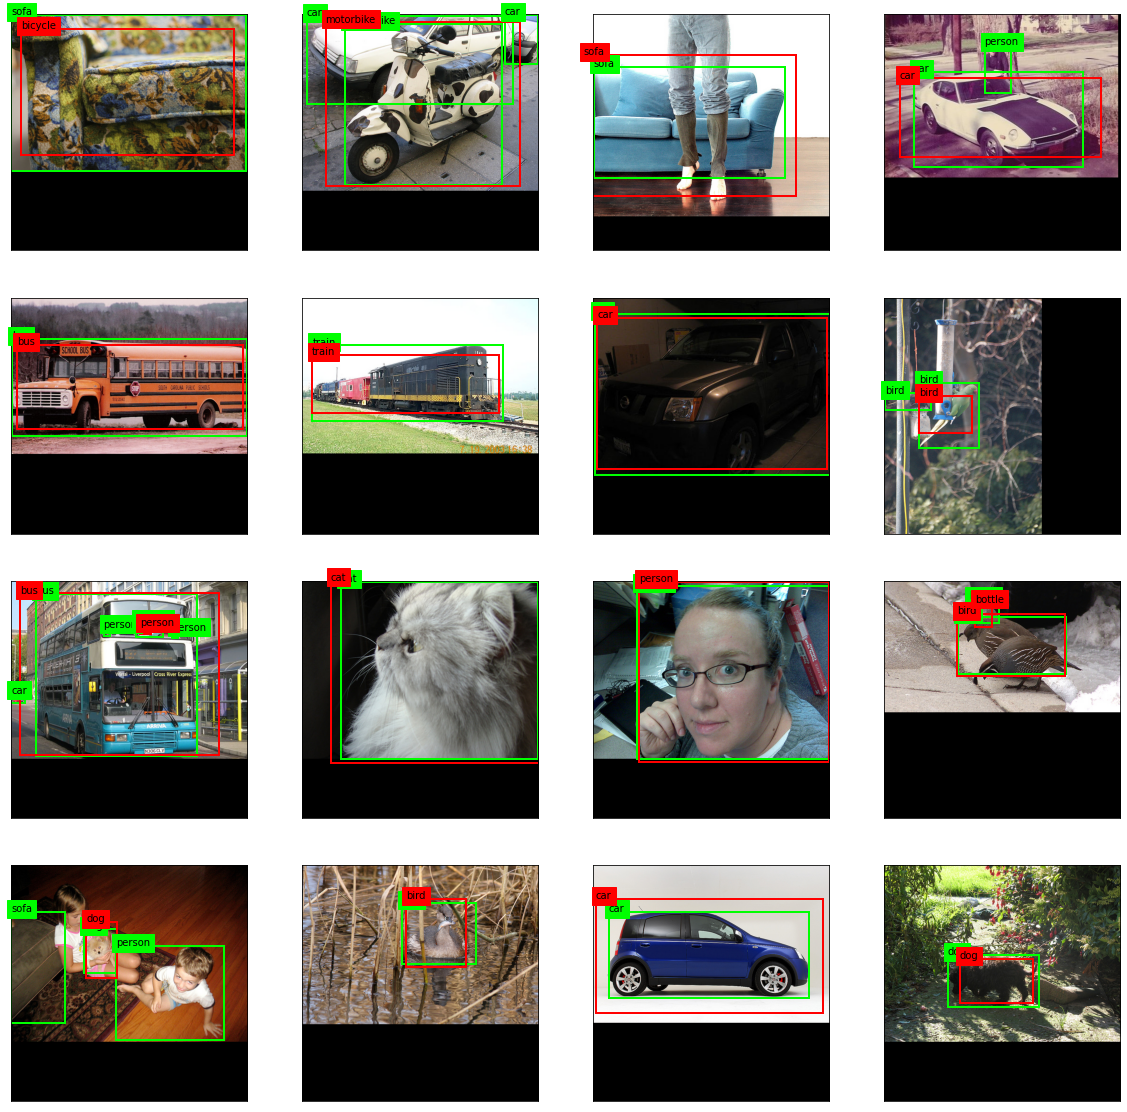

In [66]:
def inference():
    """
        Run trained model on a test dataset and plot the bounding boxes.
        1. load model
        2. get batch of sample data and labels
        3. run inference, nms on data
        4. Plot post-nms preds and labels on image.
    """

    with torch.no_grad():
        download_voc_detection_dataset(dataset_path=DATASET_PATH)

        device = DEVICE

        train_dataset, val_dataset = create_voc_datasets(dataset_path=DATASET_PATH, img_size=IMG_SIZE, S=S, B=B, C=C)
        train_dataloader, val_dataloader = create_voc_dataloaders(train_data=train_dataset, val_data=val_dataset, batch_size=BATCH_SIZE)

        model = YoloNet(S=S,B=B,C=C).to(device)
        prev_epoch, _, _, _ = load_checkpoint(torch.load(LOAD_MODEL_FILE), model)
        model.eval()

        data, labels = next(iter(train_dataloader))  # get a sample from training set
        data, labels = data.to(device), labels.to(device)
        true_boxes = get_label_boxes(labels=labels,S=S,C=C,device=device)
        # print(true_boxes[:,-1])

        preds = model(data).to(device)
        preds_boxes = get_preds_boxes(preds, S,B,C,device=device)
        preds_boxes = batched_multiclass_nms(preds_boxes=preds_boxes,
                                        S=S,
                                        B=B,
                                        C=C,
                                        pc_threshold=PC_THRESHOLD, 
                                        iou_threshold=0.5, 
                                        device=device)

        plot_detections(data,preds_boxes,true_boxes,batch_size=BATCH_SIZE,format="corner")

    return
    
    

def plot_detections(data,preds_boxes,true_boxes,batch_size,format="corner"):

    data = data.to('cpu')
    torch.manual_seed(123)

    plt.figure(figsize = (20,20))
    plt.tight_layout()
    
    num_plots = batch_size
    num_columns = 4
    num_rows = num_plots/num_columns

    (class_map, _) = ToLabelMatrix.voc_class_map()

    for i in range(num_plots):
        image = data[i]
        image = np.transpose(image,(1,2,0))

        ax = plt.subplot(num_rows,num_columns,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)

        #process labels
        img_true_boxes = true_boxes[true_boxes[:,6]==i]
        for true_box in img_true_boxes:
            [xmin, ymin, xmax, ymax] = true_box[1:5]*IMG_SIZE
            w = xmax-xmin
            h = ymax-ymin
            ax.add_patch(
                Rectangle((xmin,ymin),
                            w,
                            h,
                            fill=False,
                            edgecolor='lime',
                            lw=2)
            )
            #get class name
            obj_num = true_box[-2].type(torch.int).item()
            obj_name = class_map[obj_num]
            ax.text(xmin,ymin, s=obj_name, backgroundcolor='lime') #obj_name 


        #process detections
        img_preds_boxes = preds_boxes[preds_boxes[:,6]==i]
        for preds_box in img_preds_boxes:
            [xmin, ymin, xmax, ymax] = preds_box[1:5]*IMG_SIZE
            w = xmax-xmin
            h = ymax-ymin
            ax.add_patch(
                Rectangle((xmin,ymin),
                            w,
                            h,
                            fill=False,
                            edgecolor='red',
                            lw=2)
            )
            #get class name
            obj_num = preds_box[-2].type(torch.int).item()
            obj_name = class_map[obj_num]
            ax.text(xmin,ymin, s=obj_name, backgroundcolor='red') #obj_name 

    return



inference()